In [1]:
## SQLite does not handle vector types.

# import sqlite3
# db = sqlite3.connect(:memory:) 
# dolly_data.to_sql(name='dolly_data', con=db)
# db = sqlite3.connect('dolly_data.sql')
# dolly_data = pd.read_sql("select * from dolly_data", db)
# Q = "select instruction, response, instruction_A, instruction_B, resp_A, resp_B from dolly_data limit 10"
# pd.read_sql(Q, db)

In [2]:
import pickle
import pandas as pd
import numpy as np
from corpus_characterization_utils import *

DATA_FILE = 'dolly_data_paraphrase-MiniLM-L6-v2.parquet' # 'dolly_data_all-mpnet-base-v2.parquet'
dolly_data = pd.read_parquet(DATA_FILE).rename(columns={
    'inst_A':'instruction_A', 'inst_B':'instruction_B',
    'resp_A':'response_A', 'resp_B': 'response_B',
})
dolly_data

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,response_B
10398,What is the difference between a sitar and a t...,,Both the sitar and tanpura are string music in...,open_qa,False,"[0.23483841121196747, 0.035424668341875076, -0...","[0.02909657545387745, -0.08276070654392242, -0...",inst_A05,inst_B18,resp_A01,resp_B01
6297,"What other names are used to refer to Taweret,...",,The Egyptian goddess Taweret can be called Tao...,brainstorming,False,"[0.028640462085604668, -0.04502580687403679, 0...","[0.01769942231476307, -0.03353055194020271, 0....",inst_A06,inst_B20,resp_A01,resp_B01
7594,Which clef does a viola use?,,Viola music is normally written in the alto cl...,open_qa,False,"[-0.20119798183441162, -0.1589512676000595, -0...","[0.09287530183792114, -0.35041919350624084, -0...",inst_A11,inst_B49,resp_A01,resp_B01
19,Identify which instrument is string or percuss...,,"Gudok is string, Cantaro is percussion.",classification,False,"[-0.18485240638256073, -0.027914080768823624, ...","[-0.2516822814941406, -0.1835927963256836, -0....",inst_A19,inst_B89,resp_A01,resp_B01
27,Identify which instrument is string or woodwin...,,"Zurna is woodwind, Panduri is string.",classification,False,"[-0.22956393659114838, -0.24614019691944122, -...","[-0.1515255868434906, -0.3654420077800751, -0....",inst_A19,inst_B89,resp_A01,resp_B01
...,...,...,...,...,...,...,...,...,...,...,...
3456,Please describe a fantasy animal,,"An unicorn, a white horse like animal with a h...",creative_writing,False,"[0.030400415882468224, -0.08273373544216156, -...","[0.3746623694896698, 0.6694211959838867, 0.376...",inst_A20,inst_B94,resp_A19,resp_B90
6894,Do you know the species Etlingera diepenhorstii,Etlingera diepenhorstii is a monocotyledonous ...,"Yes, I do. The Etlingera diepenhorstii is a mo...",closed_qa,True,"[0.059478309005498886, 0.02639728970825672, -0...","[0.05170847848057747, -0.032989997416734695, -...",inst_A20,inst_B94,resp_A19,resp_B90
9076,Where is Dieveniskes located,Dieveniškės (in Lithuanian literally: Place of...,"Dieveniskes, in Lithuanian literally: Place of...",closed_qa,True,"[0.453119695186615, 0.1959957331418991, -0.753...","[0.8189837336540222, 0.14413608610630035, -0.4...",inst_A20,inst_B94,resp_A19,resp_B90
957,"How are the characters Balrog, Vega and M. Bis...","Balrog, an American boxer with a similar appea...","Balrog, an American boxer who resembles Mike T...",summarization,True,"[-0.4810430407524109, -0.26525139808654785, -0...","[-0.33796077966690063, -0.09938829392194748, -...",inst_A20,inst_B95,resp_A19,resp_B90


In [3]:
len(dolly_data['instruction_vector'][0])

384

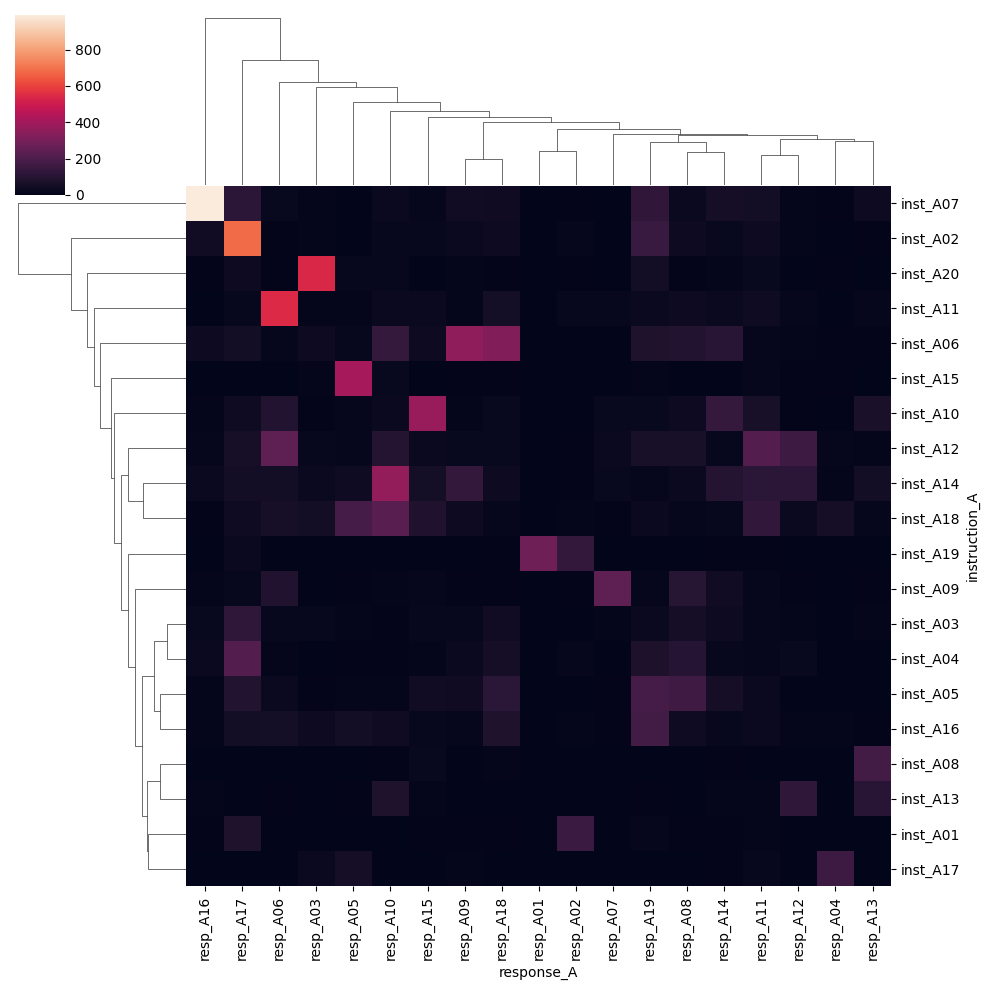

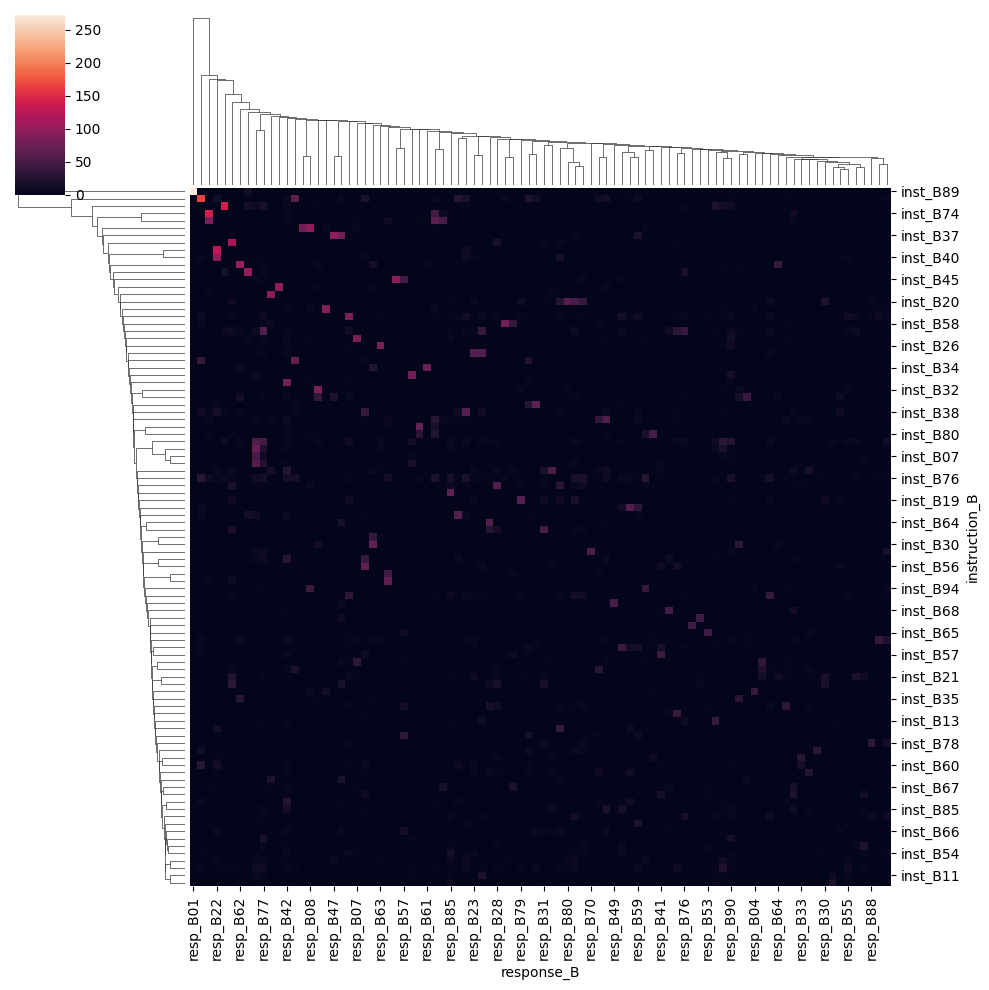

In [4]:
import seaborn as sns

for letter in 'AB':
    X = pd.crosstab(dolly_data[f'instruction_{letter}'], dolly_data[f'response_{letter}'])
    sns.clustermap(X)

# Co-occurrence

In [5]:
dd_wide = dolly_data[ ['category', 'instruction_B', 'response_B'] ] \
    .reset_index() \
    .rename(columns={'index':'basket', 'instruction_B': 'instruction_cluster', 'response_B': 'response_cluster'})

basket_item = pd.melt(dd_wide, 
                        id_vars='basket', 
                        value_vars=['category', 'instruction_cluster', 'response_cluster'],
                        var_name='type', value_name='thing'
                     ).sort_values(['basket', 'type'])

basket_item['item'] = basket_item['type'] + '::' + basket_item['thing']

basket_item = basket_item[ ['basket', 'item']]

basket_item

,basket,item
4651,0,category::closed_qa
19662,0,instruction_cluster::inst_B38
34673,0,response_cluster::resp_B25
8845,1,category::classification
23856,1,instruction_cluster::inst_B93
...,...,...
18318,15009,instruction_cluster::inst_B49
33329,15009,response_cluster::resp_B19
11406,15010,category::general_qa
26417,15010,instruction_cluster::inst_B56


In [6]:
def get_item_pair_stats(item_pair_df):
    # item_pair_df must have columns named 'basket', and 'item'.
    
    import sqlite3

    db = sqlite3.connect(":memory:")
    
    item_pair_df.to_sql("basket_item", db, if_exists="replace")


    ITEM_PAIR_STATS_QUERY = """with 
      bi as (
        select basket, item
          from basket_item
          group by basket, item  -- be sure we only count one of each kind of item per basket
      ),
      item_counts as (
        select item, count(*) item_count -- same as the number of baskets containing this item (see above)
          from bi
          group by item
      ),
      bi_count as (
        select bi.*, ic.item_count  -- basket, item, item_count
          from bi
            join item_counts ic on bi.item=ic.item
      ),
      ips as (
          select bi1.item item1, bi2.item item2,
                  bi1.item_count item1_count, bi2.item_count item2_count,
                  count(*) as both_count              
              from bi_count bi1
                join bi_count bi2  -- joining the table to itself
                  on bi1.basket = bi2.basket  -- two items in the same basket
                  and bi1.item != bi2.item    -- don't count the item being in the basket with itself
              group by bi1.item, bi1.item_count, 
                       bi2.item, bi2.item_count
      ),
      cc as (
        SELECT item1, item2, item1_count, item2_count, both_count,
              CAST(item1_count AS FLOAT)/(select count(distinct basket) from basket_item) as item1_prevalence, -- fraction of all baskets with item1
              CAST(item2_count AS FLOAT)/(select count(distinct basket) from basket_item) as item2_prevalence, -- fraction of all baskets with item2
              CAST(both_count AS FLOAT)/CAST(item1_count AS FLOAT) AS confidence  -- fraction of baskets with item1 that also have item2
          FROM ips
      )
    select *, confidence/item2_prevalence lift from cc
    """

    return pd.read_sql_query(ITEM_PAIR_STATS_QUERY, db)


def get_nodes_and_edges_from_item_pair_stats(cooccurrence_pdf):
    """
    Convert a Pandas dataframe of item-pair statistics to separate dataframes for nodes and edges.
    """
    from collections import Counter
    
    item_stats = {r['item1']:{'count':r['item1_count'], 'prevalence':r['item1_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()}
 
    item_stats.update({r['item2']:{'count':r['item2_count'], 'prevalence':r['item2_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()})
 
    nodes_df = pd.DataFrame([{'label':k,'count':v['count'], 'prevalence':v['prevalence']}  
                    for k,v in item_stats.items()])
    nodes_df['id'] = nodes_df.index
   
    edges_df = cooccurrence_pdf.copy()
    node_id = {r['label']:r['id'] for idx, r in nodes_df.iterrows()}
    edges_df['from'] = [node_id[nn] for nn in edges_df['item1']]
    edges_df['to'] = [node_id[nn] for nn in edges_df['item2']]
    
    print("Your graph will have {0} nodes and {1} edges.".format( len(nodes_df), len(edges_df) ))
 
    return nodes_df, edges_df[[ 'from', 'to', 'both_count', 'confidence', 'lift']]


def get_vis_js_html(nodes_df, edges_df):
    """
    Generate HTML encoding vis_js graph from Pandas dataframes of nodes and edges.
    """
    nodes_str = nodes_df.to_json(orient='records')
    edges_str = edges_df.to_json(orient='records')
    
    max_weight = max(edges_df['weight'])

    html_string = ( 
    '     <style type="text/css">#mynetwork {width: 100%; height: 1000px; border: 3px}</style>\n'
    '     <button onclick=toggle_motion()>Toggle motion</button>\n'
    '     <div class="slidercontainer">\n'
    '            <label>minimum edge weight:\n'
    f'                <input type="range" min="0" max="{max_weight}" value="{max_weight/2}" step="{max_weight/100}" class="slider" id="min_edge_weight">\n'
    '                <input type="text" id="min_edge_weight_display" size="2">\n'
    '            </label>\n'
    '     </div>\n'
    '     <div id="mynetwork"></div>\n'
    f'     <script type="text/javascript">NODE_LIST={nodes_str};FULL_EDGE_LIST={edges_str};</script>\n'
    '     <script type="text/javascript" src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>\n'
    '     <script type="text/javascript">\n'
    '       const sign_color = {pos:"blue", neg:"red", zero:"black"}\n'
    '       const options = {physics:{maxVelocity: 1, minVelocity: 0.01}}\n'
    '       var edgeFilterSlider\n'
    '       var mynetwork\n'
    '       var motion_flag = false\n'
    '       function toggle_motion(){\n'
    '           motion_flag = !motion_flag\n'
    '           mynetwork.setOptions( { physics: motion_flag } )\n'
    '       }\n'
    '       function edgesFilter(edge){ return edge.value >= edgeFilterSlider.value }\n'
    '       function init_network(){\n'
    '           document.getElementById("min_edge_weight_display").value = 0.5\n'
    '           document.getElementById("min_edge_weight").onchange = function(){\n'
    '               document.getElementById("min_edge_weight_display").value = this.value\n'
    '           }\n'
    '           edgeFilterSlider = document.getElementById("min_edge_weight")\n'
    '           edgeFilterSlider.addEventListener("change", (e) => {edgesView.refresh()})\n'
    '           var container = document.getElementById("mynetwork")\n'
    '           var EDGE_LIST = []\n'
    '           for (var i = 0; i < FULL_EDGE_LIST.length; i++) {\n'
    '               var edge = FULL_EDGE_LIST[i]\n'
    '               edge["value"] = Math.abs(edge["weight"])\n'
    '               edge["title"] = "weight " + edge["weight"]\n'
    '               edge["sign"] = (edge["weight"] < 0) ? "neg" : "pos";\n'
    '               edge["color"] = {color: sign_color[edge["sign"]] };\n'
    '               edge["arrows"] = "to"\n'
    '               EDGE_LIST.push(edge)\n'
    '           }\n'
    '           var nodes = new vis.DataSet(NODE_LIST)\n'
    '           var edges = new vis.DataSet(EDGE_LIST)\n'
    '           var nodesView = new vis.DataView(nodes)\n'
    '           var edgesView = new vis.DataView(edges, { filter: edgesFilter })\n'
    '           var data = { nodes: nodesView, edges: edgesView }\n'
    '           mynetwork = new vis.Network(container, data, options)\n'
    '       }\n'
    '       init_network()\n'
    '     </script>\n'

    )
    return html_string


def export_to_vis_js(nodes_df, edges_df, title, html_file_name):
    """
    Generate vis_js graph from Pandas dataframes of nodes and edges, and write to HTML file.
    """
    
    vis_js_html = get_vis_js_html(nodes_df, edges_df)
    page_html =  ('<!DOCTYPE html>\n'
        '<html lang="en">\n'
        '    <head>\n'
        f'       <title>{title}</title>\n'
        '    </head>\n'
        '    <body onload=init_network()>\n'
        f'{vis_js_html}'
        '\n'
        '    </body>\n'
        '</html>\n')
    
    with open(html_file_name, "wt") as html_file: 
        html_file.write(page_html)

In [7]:
item_pair_stats = get_item_pair_stats(basket_item)

item_pair_stats.sort_values('confidence', ascending=False)[0:15]

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
1706,instruction_cluster::inst_B09,category::information_extraction,141,1506,141,0.009393,0.100326,1.000000,9.967463
1471,instruction_cluster::inst_B02,category::open_qa,50,3742,49,0.003331,0.249284,0.980000,3.931261
4921,response_cluster::resp_B01,instruction_cluster::inst_B89,279,292,272,0.018586,0.019452,0.974910,50.117739
4913,response_cluster::resp_B01,category::classification,279,2136,270,0.018586,0.142296,0.967742,6.800924
5033,response_cluster::resp_B06,instruction_cluster::inst_B95,81,208,78,0.005396,0.013857,0.962963,69.495370
5028,response_cluster::resp_B06,category::classification,81,2136,78,0.005396,0.142296,0.962963,6.767339
4727,instruction_cluster::inst_B89,category::classification,292,2136,277,0.019452,0.142296,0.948630,6.666614
4732,instruction_cluster::inst_B89,response_cluster::resp_B01,292,279,272,0.019452,0.018586,0.931507,50.117739
7475,response_cluster::resp_B70,instruction_cluster::inst_B06,60,111,55,0.003997,0.007395,0.916667,123.964715
3009,instruction_cluster::inst_B41,category::classification,113,2136,103,0.007528,0.142296,0.911504,6.405708


In [8]:
nodes, edges = get_nodes_and_edges_from_item_pair_stats( item_pair_stats[ item_pair_stats['both_count'] > 15 ] )

nodes = nodes.rename(columns={'label':'type_label'})
nodes

Your graph will have 193 nodes and 1660 edges.


,type_label,count,prevalence,id
0,category::brainstorming,1766,0.117647,0
1,category::classification,2136,0.142296,1
2,category::closed_qa,1773,0.118113,2
3,category::creative_writing,709,0.047232,3
4,category::general_qa,2191,0.145960,4
...,...,...,...,...
188,response_cluster::resp_B86,102,0.006795,188
189,response_cluster::resp_B87,262,0.017454,189
190,response_cluster::resp_B88,78,0.005196,190
191,response_cluster::resp_B89,142,0.009460,191


In [9]:
type_color = {'category': '#FF9999', 'instruction_cluster': '#99FFFF', 'response_cluster': '#FFFF99'}

# use different shapes for categories that use context and those that do not
category_shape = {'brainstorming': 'box', 'classification': 'box', 'creative_writing': 'box', 
                  'general_qa': 'box', 'open_qa': 'box',
                  'closed_qa': 'star', 'information_extraction': 'star', 'summarization': 'star',
                  'instruction_cluster': 'ellipse', 'response_cluster': 'ellipse'}

nodes['type'] = [ x.split('::')[0] for x in nodes['type_label'] ]
nodes['label'] = [ x.split('::')[1] for x in nodes['type_label'] ]     # text displayed on the node
nodes['color'] = [ type_color[my_type] for my_type in nodes['type'] ]

   
nodes['shape'] = [ category_shape[row['label']] if row['type'] == 'category' else 'ellipse' for row in nodes.to_dict(orient='records') ]

def make_node_title(row, text_df):
    title = f"{row['label']}\n({row['type']}, {row['count']} examples)"
    if row['type'] == 'instruction_cluster':
        cluster_id = row['label']
        examples = text_df[ text_df['instruction_B'] == cluster_id ]['instruction'].sample(6).values
        title += '\n' + '\n'.join(examples)
    if row['type'] == 'response_cluster':
        cluster_id = row['label']
        examples = text_df[ text_df['response_B'] == cluster_id ]['response'].sample(6).values
        title += '\n' + '\n'.join(examples)        
    return title

nodes['title'] = [ make_node_title(row, dolly_data) for row in nodes.to_dict(orient='records') ]


nodes

,type_label,count,prevalence,id,type,label,color,shape,title
0,category::brainstorming,1766,0.117647,0,category,brainstorming,#FF9999,box,"brainstorming\n(category, 1766 examples)"
1,category::classification,2136,0.142296,1,category,classification,#FF9999,box,"classification\n(category, 2136 examples)"
2,category::closed_qa,1773,0.118113,2,category,closed_qa,#FF9999,star,"closed_qa\n(category, 1773 examples)"
3,category::creative_writing,709,0.047232,3,category,creative_writing,#FF9999,box,"creative_writing\n(category, 709 examples)"
4,category::general_qa,2191,0.145960,4,category,general_qa,#FF9999,box,"general_qa\n(category, 2191 examples)"
...,...,...,...,...,...,...,...,...,...
188,response_cluster::resp_B86,102,0.006795,188,response_cluster,resp_B86,#FFFF99,ellipse,"resp_B86\n(response_cluster, 102 examples)\nFo..."
189,response_cluster::resp_B87,262,0.017454,189,response_cluster,resp_B87,#FFFF99,ellipse,"resp_B87\n(response_cluster, 262 examples)\nIn..."
190,response_cluster::resp_B88,78,0.005196,190,response_cluster,resp_B88,#FFFF99,ellipse,"resp_B88\n(response_cluster, 78 examples)\nChi..."
191,response_cluster::resp_B89,142,0.009460,191,response_cluster,resp_B89,#FFFF99,ellipse,"resp_B89\n(response_cluster, 142 examples)\nSh..."


In [10]:
edges['weight'] = edges['confidence']

edges[edges['weight'] > 0.25]

,from,to,both_count,confidence,lift,weight
1426,8,6,99,0.335593,1.346229,0.335593
1429,8,105,139,0.471186,32.897580,0.471186
1471,9,6,49,0.980000,3.931261,0.980000
1480,9,179,17,0.340000,13.831274,0.340000
1492,10,6,114,0.300000,1.203447,0.300000
...,...,...,...,...,...,...
8195,189,6,76,0.290076,1.163639,0.290076
8209,189,23,86,0.328244,15.207638,0.328244
8244,190,2,22,0.282051,2.387971,0.282051
8268,190,85,33,0.423077,64.149573,0.423077


In [11]:
export_to_vis_js(nodes, edges[edges['confidence'] > 0.25], title="Cluster co-occurrence", html_file_name='cluster_cooccurrence.html')

In [12]:
# vis_js_html = get_vis_js_html(nodes, edges[edges['confidence'] > 0.25])
# from IPython.display import HTML
# HTML(vis_js_html)

# Predicting Patterns

In [13]:
pat = r"\b(book(?!: a )|books|novel|literature|literary)\b"  # 'book' but not 'book a flight'


# to do: exclude 'computer science', 'political science', 'data science', 'science fiction'
# This doesn't work: 
# None: 'tabular'
# r'\b(reference|following) text' # 'story about' write a|(story about|diary entry)

# 'Write a short story about a woman named '
# r'\b(both sides|pro and con|pros and cons|for and against)' # 'argument'
# Please fix the typos and grammar issues in the following text

import regex  # allows alternatives in negative lookarounds
[ x for x in dolly_data['instruction']  if regex.search(pat, x, regex.IGNORECASE) ]

['What are the benefits of audio books over physical books?',
 'Based on this paragraph, extract the names of the books about Phish and list them using bullets.',
 'List a few queer books made popular by TikTok',
 'I\'m going to give you a passage from Marty Essen\'s book "Cool Creatures, Hot Planet: Exploring the Seven Continents" and want you to answer the following question: Where are western Hermann\'s tortoises found?\n\nAfter spending the night at a large chain hotel, Deb and I traveled southeast with tortoises on our mind. Our plan for the day was to infiltrate the Massif des Maures area and search for one of France\'s most endangered reptiles-- the western Hermann\'s tortoise.  The first stop of our quest was Le Village de Tortues (the Tortoise Village), a tortoise rehabilitation center near the town of Gonfaron. Our mission was to befriend a staff member, learn as much as we could, and get detailed information on tracking down the wily Hermann\'s tortoise in the wild. When we 

In [14]:
import regex # allows alternatives in negative lookarounds
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Prefixing patterns by r'\b' ensures they must be at the beginning of a word. 
# This way 'eat' does not match 'great', and most plurals will be OK.
patterns = { 
    # domains
    'cars': r"\b(automobile|car|Toyota|Ford|Dodge|Jeep|Fiat)",
    'animals': r"\b(animal|cat|dog|pet)",
    'food': r"\b(food|diet|eat|restaurant)",
    'programming_language': r"\bprogramming language",
    'sports': r'\baseball(?!: bat)|basketball|badminton|tennis(?!: shoe)|soccer|futbol|football (?!: stadium)',
    'science': r"(?<![:?])(?<!(computer|political|data)) science (?!fiction)|biology|(?<!blood )chemistry|physics|astromony",
    'science_fiction': r"science fiction",
    'data_science': r"data science|machine learning|statistic|quantitative|probability|artificial intelligence|AI\b",
    'information_technology': r"technology|software|information|open source|spark",
    'books': r"\b(book(?!: a )|books|novel|literature|literary)\b",  # 'book' but not 'book a flight'

    # instruction structure
    'given_text': r"\b(given a|given the|the given|based on|reference text|as a reference|the following text)",  # passage|paragraph

    # output format
    'output_format': r"(the results|as a (bulleted )?list|list them|format this|format them|in the format|each record|new line|comma separated|separated by|JSON|XML|markdown)", 
    
}

models = {}

for text_col in ['instruction', 'response']:
    vector_col = text_col + "_vector"
    l1_ratios = [0.01, 0.1, 0.5]
    X = [v for v in dolly_data[vector_col]]
    for topic in patterns.keys():
        pattern = patterns[topic]
        flag_col = text_col + '_' + topic
        score_col = flag_col + '_score'
        flags = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in dolly_data[text_col]]
        # clf = LogisticRegression(C=1, max_iter=10000)
        clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
        # clf = LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=l1_ratios, scoring='roc_auc', max_iter=10000)
        clf.fit(X, flags)
        models[flag_col] = clf
        dolly_data[flag_col] = flags
        dolly_data[score_col] = clf.predict_proba(X)[:,1]

pickle.dump(models, open('models_LogisticRegressionCV_l2.pkl', 'wb'))

In [15]:
def swap_parts(col_name):
    parts = col_name.split('_')
    return parts[1] + '_' + parts[0]

score_cols = [col_name for col_name in dolly_data.columns if '_score' in col_name]
score_cols.sort(key=swap_parts)

M_corr = dolly_data[score_cols].corr()
M_corr

,instruction_animals_score,response_animals_score,instruction_books_score,response_books_score,instruction_cars_score,response_cars_score,instruction_data_science_score,response_data_science_score,instruction_food_score,response_food_score,...,instruction_output_format_score,response_output_format_score,instruction_programming_language_score,response_programming_language_score,instruction_science_score,instruction_science_fiction_score,response_science_score,response_science_fiction_score,instruction_sports_score,response_sports_score
instruction_animals_score,1.000000,0.626319,-0.013617,-0.031889,0.058038,0.019508,-0.024441,-0.051208,0.042013,0.026126,...,-0.019894,-0.043036,0.005243,-0.046898,-0.006691,-0.000334,-0.030616,-0.010290,-0.027952,-0.044938
response_animals_score,0.626319,1.000000,0.015298,0.045438,0.027600,0.190326,-0.025555,-0.009659,0.058165,0.167085,...,-0.033700,-0.006349,-0.005236,0.020003,0.017480,0.002709,0.048847,0.014509,-0.020999,-0.013038
instruction_books_score,-0.013617,0.015298,1.000000,0.532082,-0.010168,-0.015465,-0.008251,-0.017649,-0.008087,-0.026409,...,-0.010721,-0.019200,-0.005737,-0.024572,0.017422,0.176889,0.035664,0.217257,-0.025201,-0.038330
response_books_score,-0.031889,0.045438,0.532082,1.000000,-0.029572,0.069839,-0.012146,0.012471,-0.021974,0.009839,...,-0.024292,0.005375,-0.005217,0.031938,0.022323,0.133917,0.100233,0.233782,-0.041855,-0.057363
instruction_cars_score,0.058038,0.027600,-0.010168,-0.029572,1.000000,0.427337,0.022243,-0.011957,0.015043,-0.013368,...,-0.019770,-0.032255,-0.009471,-0.058311,-0.005862,-0.006250,-0.029660,-0.011965,0.015586,0.011307
response_cars_score,0.019508,0.190326,-0.015465,0.069839,0.427337,1.000000,-0.011466,0.023932,0.050486,0.218583,...,-0.033405,0.004480,-0.021230,-0.026958,-0.005953,0.001065,0.027236,-0.007123,-0.001790,0.021868
instruction_data_science_score,-0.024441,-0.025555,-0.008251,-0.012146,0.022243,-0.011466,1.000000,0.545230,-0.000100,-0.023118,...,-0.012235,0.043709,-0.004688,0.087938,0.033945,-0.000418,0.032014,-0.001264,-0.009510,-0.014022
response_data_science_score,-0.051208,-0.009659,-0.017649,0.012471,-0.011957,0.023932,0.545230,1.000000,-0.008167,-0.007672,...,-0.002647,0.128488,0.018407,0.204897,0.037902,-0.002191,0.157163,0.009739,-0.025076,-0.026552
instruction_food_score,0.042013,0.058165,-0.008087,-0.021974,0.015043,0.050486,-0.000100,-0.008167,1.000000,0.495293,...,-0.015141,-0.009000,-0.006117,-0.007522,-0.007643,-0.004379,-0.018904,-0.010554,-0.023899,-0.029951
response_food_score,0.026126,0.167085,-0.026409,0.009839,-0.013368,0.218583,-0.023118,-0.007672,0.495293,1.000000,...,-0.040484,0.012197,-0.010081,-0.030450,-0.012796,-0.008946,-0.006029,-0.017361,-0.051222,-0.055267


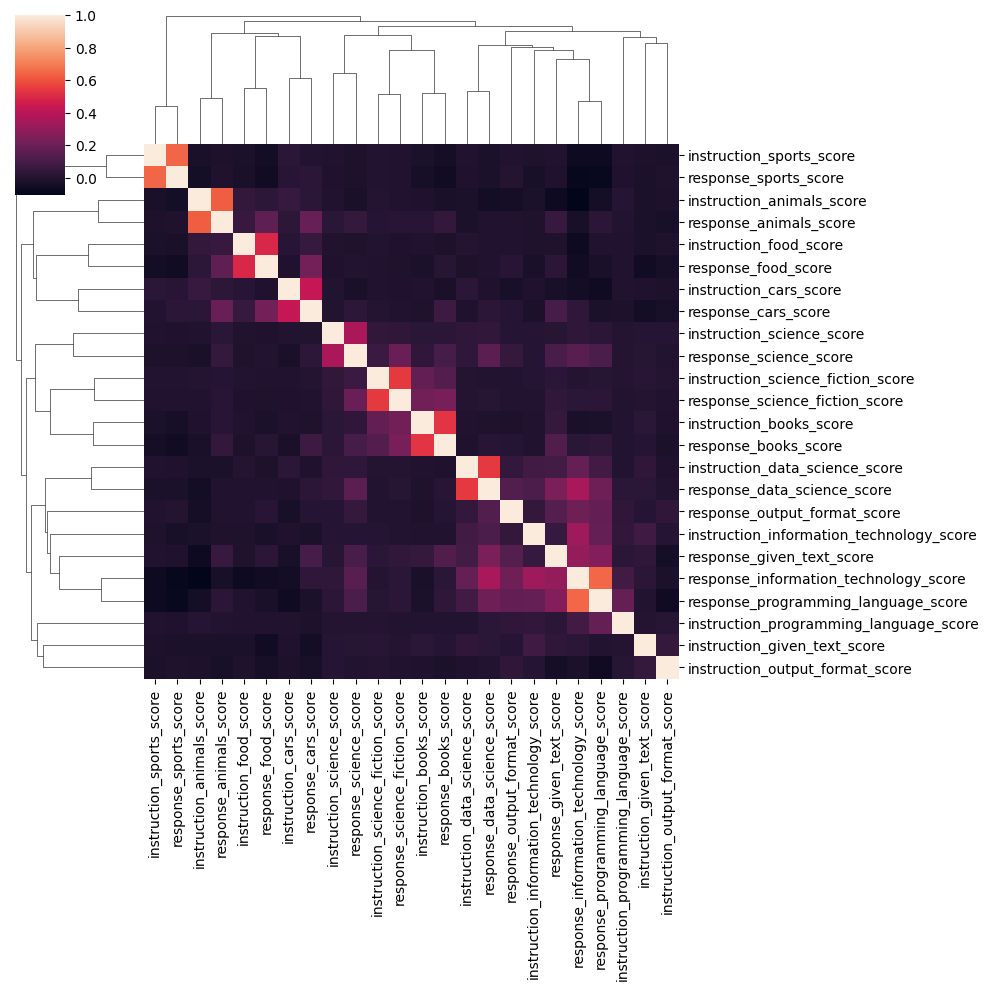

In [16]:
sns.clustermap(M_corr)

In [17]:
# pd.DataFrame([{'topic': topic, 'coef': models[topic].coef_[0]} for topic in models.keys()])
M_coef = pd.DataFrame([models[topic].coef_[0] for topic in models.keys()] , index=[k for k in models.keys()]).transpose()
M_coef

,instruction_cars,instruction_animals,instruction_food,instruction_programming_language,instruction_sports,instruction_science,instruction_science_fiction,instruction_data_science,instruction_information_technology,instruction_books,...,response_food,response_programming_language,response_sports,response_science,response_science_fiction,response_data_science,response_information_technology,response_books,response_given_text,response_output_format
0,-0.488478,0.243785,0.348840,-1.106272,-0.038342,0.036440,0.440293,0.197081,-0.029471,0.241556,...,0.227655,-0.001576,0.123228,0.055571,0.032185,0.342207,-0.162479,0.380971,-0.710235,-0.117294
1,-0.325224,-0.131794,-0.207584,-0.218397,0.005773,0.110600,0.395720,-0.314261,0.198014,0.208046,...,0.255197,-0.001125,-0.007615,-0.259955,-0.299724,-0.031190,-0.078683,0.355345,0.635791,0.225579
2,0.715093,-0.095605,0.421665,-0.659020,0.330809,0.117338,1.588463,0.165624,-0.342939,-0.729266,...,0.296988,-0.002261,0.002095,0.198375,0.022330,-0.271558,-0.144304,-0.777428,0.010699,0.197717
3,-0.504342,0.302549,0.452440,-0.413710,-0.207974,-0.011012,1.480092,0.121938,-0.258631,0.114967,...,-0.466434,-0.001204,-0.281299,-0.300061,-0.008057,0.050071,-0.193820,0.205537,-0.653831,-0.451532
4,0.340033,-0.093545,0.032331,-0.589343,-0.009197,0.019203,0.181524,0.338501,-0.179392,-0.182615,...,0.073891,-0.000399,0.066506,0.183355,0.392617,0.509516,0.063254,-0.370732,0.026915,0.112793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-1.105332,0.251986,-0.249456,-0.112859,-0.169175,-0.128409,-2.204981,0.208265,-0.294343,-0.373048,...,0.394998,0.000627,-0.075320,-0.187315,-0.037212,0.400969,0.066308,-0.153320,0.057053,0.266380
380,-1.868470,0.197357,-0.156692,0.047003,-0.205182,0.116179,-1.197686,0.106640,-0.313272,0.269098,...,-0.752345,-0.000672,-0.048455,0.065243,-0.046675,-0.173138,-0.151501,-0.294433,-0.154263,0.085996
381,0.181374,-0.190517,-0.154284,-0.372386,0.134462,-0.346338,-1.163121,0.215740,-0.081455,-0.429598,...,-0.333853,0.000884,0.062438,-0.154367,-0.309930,-0.046121,0.075423,-0.109432,0.809946,0.031754
382,-1.181371,0.116803,-0.504391,-0.042643,-0.260463,0.237823,-0.904017,-0.357655,0.007862,-0.255700,...,-0.569393,0.001705,-0.003501,-0.037969,-0.467291,-0.614767,0.029169,-0.419537,-0.430846,-0.486586


In [18]:
# model = models['instruction_animals']

def get_model_stats(my_models):
    all_models_stats = []
    for topic in my_models:
        my_stats = {}
        model = my_models[topic]
        cv_scores = [ max(vc) for vc in model.scores_[True] ]  # (n_folds, n_cs)
        my_stats['topic'] = topic
        my_stats['cv_auc_mean'] = np.mean(cv_scores)
        my_stats['coef_std'] = np.std(model.coef_[0])
        my_stats['coef_mean'] = np.mean(model.coef_[0])
        my_stats['coef_min'] = np.min(model.coef_[0])
        my_stats['coef_max'] = np.max(model.coef_[0])
        all_models_stats.append(my_stats)
        
    return pd.DataFrame(all_models_stats)


model_stats = get_model_stats(models)
model_stats

,topic,cv_auc_mean,coef_std,coef_mean,coef_min,coef_max
0,instruction_cars,0.903951,0.861174,-0.021221,-2.780486,3.806375
1,instruction_animals,0.935142,0.186941,-0.003187,-0.485369,0.551460
2,instruction_food,0.983781,0.346077,-0.004225,-1.167799,1.043182
3,instruction_programming_language,0.999350,0.454326,0.002642,-1.733074,1.309754
4,instruction_sports,0.990691,0.395357,-0.007663,-1.680186,1.267721
5,instruction_science,0.977478,0.204965,-0.000952,-0.546909,0.658533
6,instruction_science_fiction,0.999305,1.151881,-0.007554,-3.620491,3.367796
7,instruction_data_science,0.911133,0.324367,-0.003105,-0.926787,0.952626
8,instruction_information_technology,0.942466,0.345626,-0.004825,-1.057268,0.973478
9,instruction_books,0.984135,0.350521,-0.002956,-1.256850,0.997617


<Axes: xlabel='cv_auc_mean', ylabel='coef_std'>

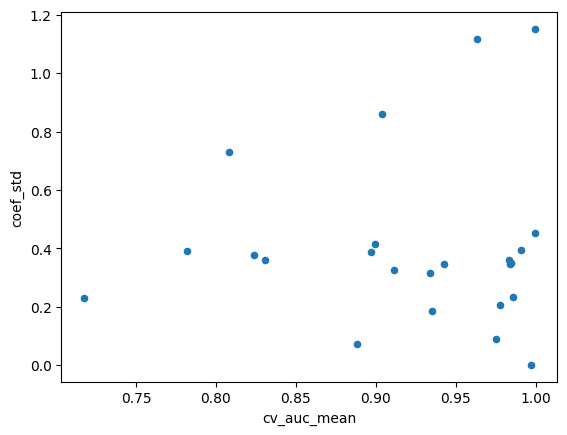

In [19]:
model_stats.plot.scatter(x='cv_auc_mean', y='coef_std')

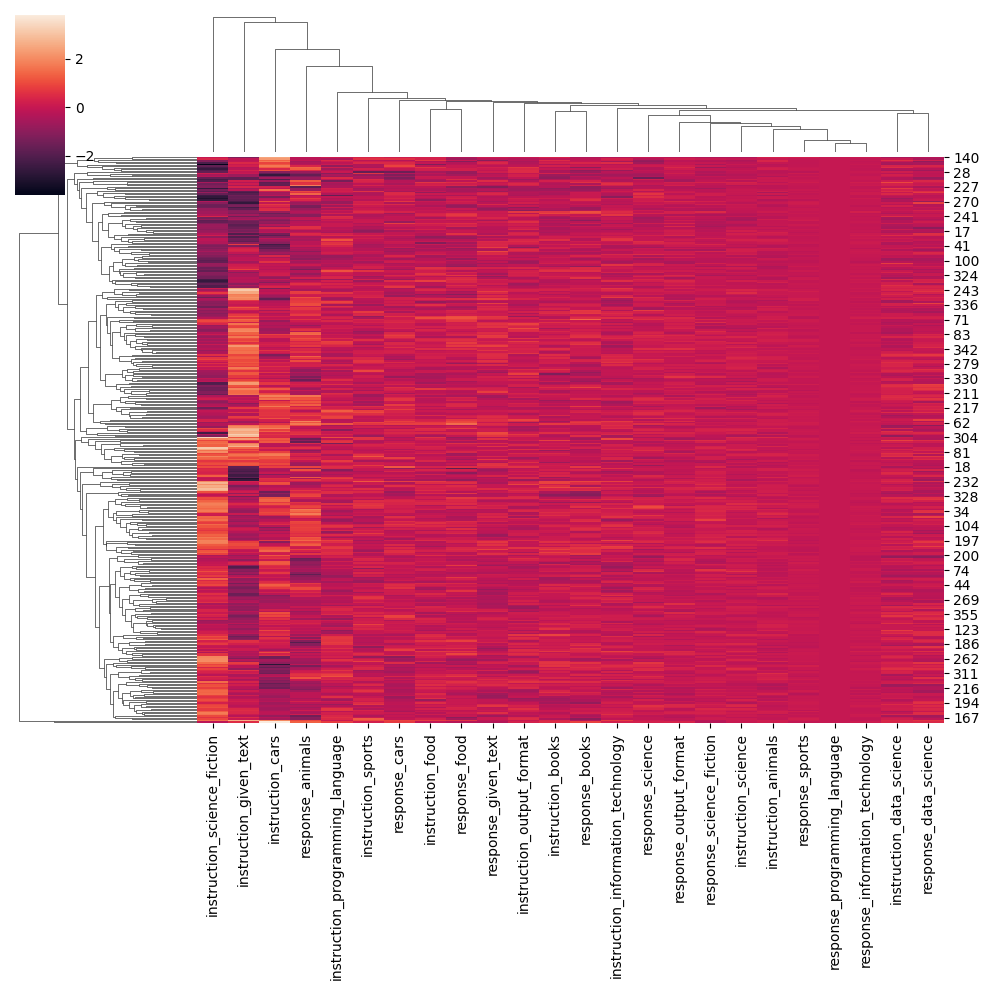

In [20]:
# plt.matshow(M_coef) # does not display

sns.clustermap(M_coef)

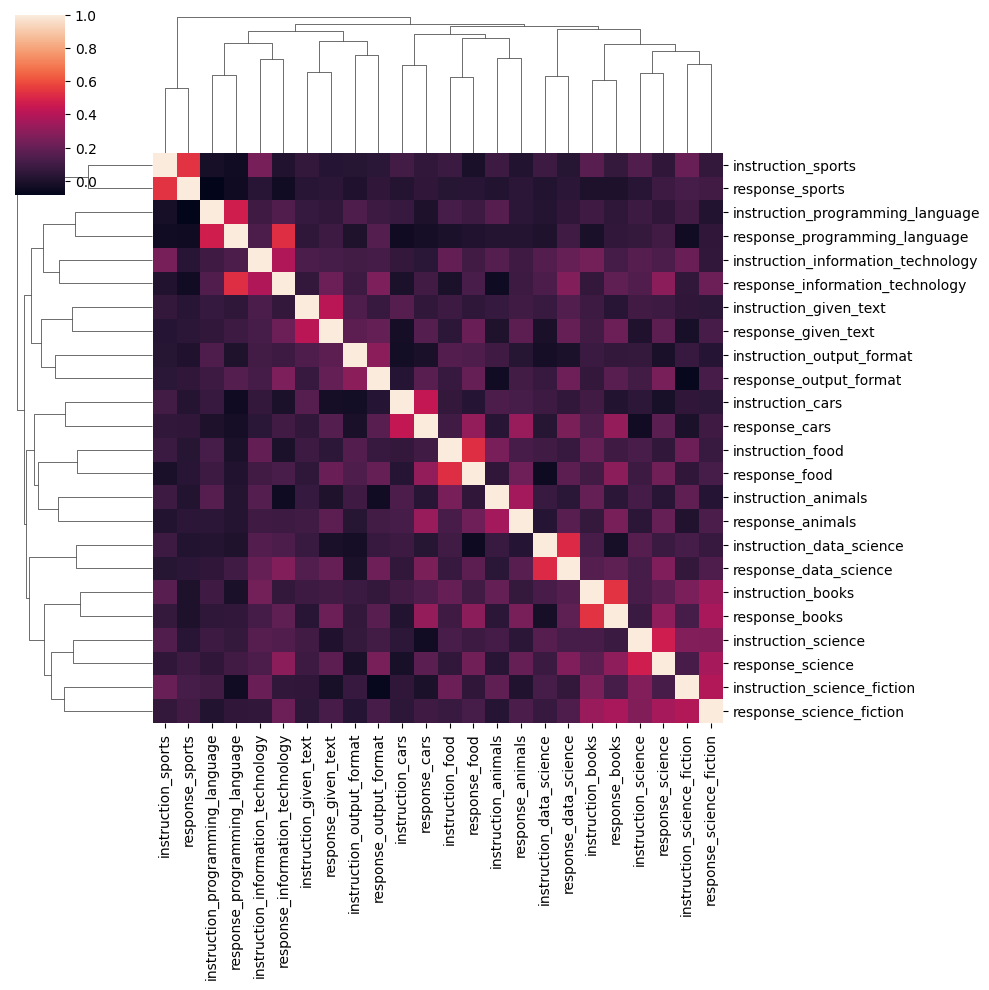

In [21]:
sns.clustermap(M_coef.corr())

In [22]:
# pd.crosstab(dolly_data['instruction_animals'], dolly_data['response_animals'])

for topic in patterns.keys():
    xtab = pd.crosstab(dolly_data[f'instruction_{topic}'], dolly_data[f'response_{topic}'])
    display(xtab)

response_cars,False,True
instruction_cars,,
False,13352,1123
True,182,354


response_animals,False,True
instruction_animals,,
False,13706,611
True,316,378


response_food,False,True
instruction_food,,
False,14262,516
True,69,164


response_programming_language,False,True
instruction_programming_language,,
False,14949,38
True,10,14


response_sports,False,True
instruction_sports,,
False,14476,192
True,101,242


response_science,False,True
instruction_science,,
False,14883,107
True,7,14


response_science_fiction,False,True
instruction_science_fiction,,
False,14974,20
True,4,13


response_data_science,False,True
instruction_data_science,,
False,14617,253
True,33,108


response_information_technology,False,True
instruction_information_technology,,
False,14396,460
True,64,91


response_books,False,True
instruction_books,,
False,14524,269
True,93,125


response_given_text,False,True
instruction_given_text,,
False,13822,361
True,785,43


response_output_format,False,True
instruction_output_format,,
False,14745,29
True,230,7


In [23]:
from IPython.display import display, HTML

def get_top_negatives(flag_col):
    text_col = flag_col.split('_')[0]
    return dolly_data[ dolly_data[flag_col] == False ] \
        .sort_values(flag_col + '_score', ascending=False) \
        .head(30)[[text_col, flag_col, flag_col + '_score', 'instruction_A']]

def tabulate_flag_matches(flag_col, threshold=0.5):
    flag_match = [score > threshold for score in dolly_data[flag_col + '_score']]
    # pd.crosstab(dolly_data['instruction_A'], dolly_data[flag_col])
    
    xtab = pd.crosstab(dolly_data['instruction_A'], flag_match)
    xtab['fraction_true'] = [ row[True]/(row[False] + row[True]) for row in xtab.to_dict(orient="records")]
    return xtab.sort_values('fraction_true', ascending=False)

# classify
# extract [... and separate them with a comma]
# write; write a short paragraph about
# instruction format: comma-separated lists, newline-separated lists
# requested format: a short bulleted list

# Jokes dolly_data.loc[8226]

In [24]:
HTML(get_top_negatives('instruction_animals').to_html())

,instruction,instruction_animals,instruction_animals_score,instruction_A
1900,What are mammals?,False,0.955541,inst_A20
1623,What is a mammal?,False,0.952605,inst_A20
9562,"Identify from this list what creatures are felines: panther, jaguar, elephant, kitten, human child, leopard, tiger, malamute, sofa",False,0.938927,inst_A20
1368,What are the characteristics of chihuahuas?,False,0.898316,inst_A20
1475,What kind of Toys should be prepare for a new puppy,False,0.885303,inst_A20
2424,"Classify each of the following as either a Carnivore or a Herbivore: Cow, Shark, Zebra, Lion, Wolf, Elephant, Tiger, Deer, Leopard, Cheetah",False,0.874758,inst_A20
1507,List of Italian horse breeds,False,0.856012,inst_A07
394,How to raise a kitten?,False,0.845894,inst_A20
28,What is the average lifespan of a Golden Retriever?,False,0.842808,inst_A20
9275,What is the biggest land mammal?,False,0.824091,inst_A06


In [25]:
display(tabulate_flag_matches('instruction_animals'))

col_0,False,True,fraction_true
instruction_A,,,
inst_A20,312,422,0.574932
inst_A17,280,8,0.027778
inst_A12,1066,14,0.012963
inst_A10,935,10,0.010582
inst_A15,491,5,0.010081
inst_A06,1302,11,0.008378
inst_A13,367,3,0.008108
inst_A11,879,5,0.005656
inst_A14,1208,5,0.004122


In [26]:
display(tabulate_flag_matches('response_animals'))

col_0,False,True,fraction_true
instruction_A,,,
inst_A20,478,256,0.348774
inst_A17,278,10,0.034722
inst_A15,479,17,0.034274
inst_A12,1050,30,0.027778
inst_A18,956,18,0.018480
inst_A10,928,17,0.017989
inst_A11,869,15,0.016968
inst_A14,1193,20,0.016488
inst_A13,364,6,0.016216


In [27]:
# Cluster inst_A20 is largely about cats and dogs

a20 = dolly_data[dolly_data['instruction_A'] == 'inst_A20'][['instruction', 'instruction_animals', 'instruction_animals_score', 'instruction_A']]
HTML(a20.to_html())

,instruction,instruction_animals,instruction_animals_score,instruction_A
2730,Which is a species of fish? Rock bass or Rock,False,0.015176,inst_A20
3677,Which is a species of fish? Bass or Treble,False,0.014223,inst_A20
11255,"What instrument plays the part of the duck in the musical composition, ""Peter and the Wolf""",True,0.101271,inst_A20
14869,Which is a species of fish? Trumpeter or Trump,False,0.126368,inst_A20
15002,Which is a species of fish? Banjo or Guitar,False,0.049287,inst_A20
56,Write a short paragraph about why you should not have both a pet cat and a pet bird.,True,0.916952,inst_A20
394,How to raise a kitten?,False,0.845894,inst_A20
1053,"Classify each of the following as either a typical cat name or dog name: Spot, Whiskers, Mittens, Buddy, Fido, Rover, Lassie, Rex, Felix, Socks, Tiger",True,0.984131,inst_A20
1447,Write a letter to my mom to convince her that I should be able to get a cat.,True,0.595100,inst_A20
1765,Why do cats purr?,True,0.929765,inst_A20


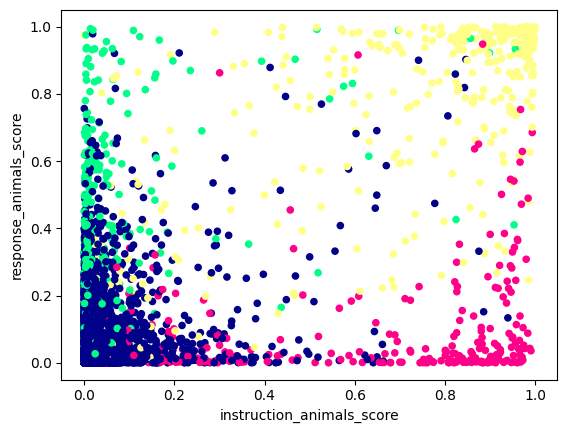

In [28]:
def flags_to_color(flag1, flag2):
    r = 'FF' if flag1 else '00'
    g = 'FF' if flag2 else '00'
    b = '88'
    return f"#{r}{g}{b}"

point_color = [ flags_to_color(row['instruction_animals'], row['response_animals']) for row in dolly_data.to_dict(orient='records') ] 
point_color
plt = dolly_data.plot.scatter('instruction_animals_score', 'response_animals_score', c=point_color)
# legend outside of plot 
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [29]:
HTML(get_top_negatives('instruction_food').to_html())

,instruction,instruction_food,instruction_food_score,instruction_A
3719,"Of the items, tomato, broccoli, plane, sausage, pineapple, grass, honey, and milk would a human not like to consume?",False,0.792635,inst_A15
11496,"Classify each of the following as edible or not edible: hamburger, toast, rubber, leather, pizza, plastic",False,0.756499,inst_A15
9983,What are some healthy lunch ideas?,False,0.694792,inst_A15
1430,Why are peanuts not kosher for Passover.,False,0.680175,inst_A06
7651,"Classify each of the following as either caloric or low-fat products: butter, turnips, oils, salad dressings, spinach, sugar, water, nuts, seeds, dry bread, zucchini, strawberries, dry cereal, crackers, tomatoes, egg yolk, avocado, dried fruit, ananas, red meat, pizza, salmon, ketchup, watermelon",False,0.664003,inst_A15
7778,"Healthy choice for kids or unhealthy: French Fries, Banana, Candy, Vegetables",False,0.655612,inst_A15
6733,List the ingredients to make the best Greek salad,False,0.605560,inst_A15
14938,What are some low fat snack options?,False,0.553927,inst_A15
3199,"Classify each of the following as healthy or unhealthy: cake, apple, broccoli, donut, candy, soda, kombucha, and ice cream",False,0.544472,inst_A15
8631,What does a typical meal look like,False,0.543656,inst_A15


In [30]:
tabulate_flag_matches('instruction_food', threshold=0.5)

col_0,False,True,fraction_true
instruction_A,,,
inst_A15,372,124,0.250000
inst_A17,278,10,0.034722
inst_A20,720,14,0.019074
inst_A13,366,4,0.010811
inst_A09,591,5,0.008389
inst_A18,967,7,0.007187
inst_A06,1304,9,0.006855
inst_A16,631,4,0.006299
inst_A14,1207,6,0.004946


In [31]:
# a15 is mostly about food
a15 = dolly_data[dolly_data['instruction_A'] == 'inst_A15'][['instruction', 'instruction_food', 'instruction_food_score']]
HTML(a15.to_html())

,instruction,instruction_food,instruction_food_score
5118,Give me a list of different cat species that are good for people with allergies.,False,0.014188
6467,Why am I allergic to cats?,False,0.036464
2918,"Classify each of these breads as either a dog or a cat bread: Siamese, Ragdoll, Yorkshire Terrier, Birman, Cocker Spaniel, Saint Bernard.",False,0.051022
1778,How do you make Crawfish bread?,False,0.040471
4963,What are crawfish and how do you eat them?,True,0.293449
9421,Where are oysters found?,False,0.057146
10281,What does an east coast oyster taste like?,False,0.069276
10425,What do west coast oysters taste like?,False,0.076387
10553,"Which of the following is a famous food in Dali County Shaanxi Province in China: Waterbasin Lamb, Roujiamo, fried dumplings",True,0.633174
4897,Please give me a list of popular street foods available in South Korea,True,0.986255


In [32]:
# Identify which [car manufacturer] is [Japanese or American]: [Honda, Buick]	  A_08

## Beyond the scop of pre-2021 training data?:
# Which of these movies were nominated for Best Picture? "All Quiet on the Western Front", "Everything Everywhere All at Once", "Avatar: The Way of Water", "Glass Onion", "Pinocchio", "Navalny", "The Whale".


## Anthropomorphism
# Who is the biggest inspiration in your life?

In [33]:
HTML(get_top_negatives('instruction_cars').to_html())

,instruction,instruction_cars,instruction_cars_score,instruction_A
7976,"Classify the vehicles based on the number of wheels use to ply on.\nAutorickshaw, SUV, Sedan, Motorcycles",False,0.965953,inst_A08
14419,"Classify each of these as ground transportation or aviation transportation: airplane, truck, bicycle, unicycle, jet, wagon, helicopter.",False,0.926400,inst_A08
10645,"Classify each of the following a muscle in the arm or leg: quadricep, bicep, tricep, forearm, calf",False,0.923751,inst_A14
12946,"Divide these sneakers into Air Jordan and Air Max: Tokyo 96, Big Bubble Red, Collector's Dream, Monarch, Chicago, Lucky Green",False,0.907026,inst_A18
10633,Who was the first Grand Prix driver to used a safety belt in 1967,False,0.883660,inst_A07
3160,"Classify which teams are in the NHL or NBA: Detroit Red Wings, Detroit Pistons, Milwaukee Bucks, Cleveland Cavaliers, Columbus Blue Jackets, Chicago Bulls, Chicago Blackhawks",False,0.845857,inst_A07
3284,"When rollerblading which of the following items will protect you from injury and which will not: Helmet, a baseball cap, sunglasses, knee pads, backpack, headphones, and elbow pads?",False,0.829505,inst_A07
7902,What is Stanley B. Goldenberg's profession?,False,0.803073,inst_A04
5400,Should I buy a convertible?,False,0.767415,inst_A08
3107,how to fight a speeding ticket?,False,0.746784,inst_A10


In [34]:
tabulate_flag_matches('instruction_cars', threshold=0.5)

col_0,False,True,fraction_true
instruction_A,,,
inst_A08,60,171,0.740260
inst_A13,359,11,0.029730
inst_A17,280,8,0.027778
inst_A12,1056,24,0.022222
inst_A09,585,11,0.018456
inst_A10,928,17,0.017989
inst_A14,1194,19,0.015664
inst_A04,589,9,0.015050
inst_A07,1546,21,0.013401


# N-gram features

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer( ngram_range=(5,9), min_df=5, stop_words=None)  # min_df==5: 2871, 10:1137
instruction_ngram_counts_matrix = count_vect.fit_transform(dolly_data['instruction'])
instruction_ngram_counts_matrix.shape

(15011, 1008)

In [36]:
instruction_ngram_counts_pdf = pd.DataFrame(data = instruction_ngram_counts_matrix.todense(), columns = count_vect.get_feature_names_out())
# HTML( instruction_ngram_counts_pdf[1:100].to_html() )

instruction_ngram_counts_pdf.columns

Index(['60 year old personal training', '60 year old personal training client',
       '60 year old personal training client wants',
       '60 year old personal training client wants to',
       '60 year old personal training client wants to improve',
       'about large language models what', 'about the history of the',
       'according to this paragraph about', 'according to this paragraph what',
       'all of the dates mentioned',
       ...
       'year old personal training client wants to',
       'year old personal training client wants to improve',
       'year old personal training client wants to improve her',
       'you are the last person', 'you are the last person on',
       'you are the last person on earth',
       'you are the last person on earth write',
       'you are the last person on earth write diary',
       'you going for walk today', 'you tell me about the'],
      dtype='object', length=1008)

In [37]:
instruction_ngram_counts_pdf.sum(axis=0)

60 year old personal training                            5
60 year old personal training client                     5
60 year old personal training client wants               5
60 year old personal training client wants to            5
60 year old personal training client wants to improve    5
                                                        ..
you are the last person on earth                         5
you are the last person on earth write                   5
you are the last person on earth write diary             5
you going for walk today                                 6
you tell me about the                                    5
Length: 1008, dtype: int64

In [38]:
instruction_ngram_counts_pdf.head()

,60 year old personal training,60 year old personal training client,60 year old personal training client wants,60 year old personal training client wants to,60 year old personal training client wants to improve,about large language models what,about the history of the,according to this paragraph about,according to this paragraph what,all of the dates mentioned,...,year old personal training client wants to,year old personal training client wants to improve,year old personal training client wants to improve her,you are the last person,you are the last person on,you are the last person on earth,you are the last person on earth write,you are the last person on earth write diary,you going for walk today,you tell me about the
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
basket_item_rows = []
for i, row in enumerate(instruction_ngram_counts_pdf.to_dict(orient="records")):
    for k, v in row.items():
        if v > 0:
            basket_item_rows.append({'basket': i, "item": k})

basket_item = pd.DataFrame(basket_item_rows)

In [40]:
basket_item

,basket,item
0,0,what is the difference between
1,3,identify which instrument is string
2,3,identify which instrument is string or
3,3,identify which instrument is string or percussion
4,3,instrument is string or percussion
...,...,...
16385,15001,the bird from the list
16386,15002,which is species of fish
16387,15003,which is species of fish
16388,15004,which is species of fish


In [41]:
item_pair_stats = get_item_pair_stats(basket_item)

item_pair_stats.sort_values('confidence', ascending=False)[0:15]

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
0,60 year old personal training,60 year old personal training client,5,5,5,0.001481,0.001481,1.0,675.400000
13619,paragraph and list them using bullets,paragraph and list them using bullets in,26,26,26,0.007699,0.007699,1.0,129.884615
13643,paragraph and list them using bullets,this paragraph and list them using,26,26,26,0.007699,0.007699,1.0,129.884615
13642,paragraph and list them using bullets,this paragraph and list them,26,28,26,0.007699,0.008291,1.0,120.607143
13638,paragraph and list them using bullets,them using bullets in the format,26,37,26,0.007699,0.010956,1.0,91.270270
13637,paragraph and list them using bullets,them using bullets in the,26,37,26,0.007699,0.010956,1.0,91.270270
13621,paragraph and list them using bullets,paragraph and list them using bullets in the f...,26,26,26,0.007699,0.007699,1.0,129.884615
13620,paragraph and list them using bullets,paragraph and list them using bullets in the,26,26,26,0.007699,0.007699,1.0,129.884615
13618,paragraph and list them using bullets,paragraph and list them using,26,26,26,0.007699,0.007699,1.0,129.884615
13645,paragraph and list them using bullets,this paragraph and list them using bullets in,26,26,26,0.007699,0.007699,1.0,129.884615


In [42]:
nodes, edges = get_nodes_and_edges_from_item_pair_stats( item_pair_stats[item_pair_stats['confidence'] > 0.5] )

edges['weight'] = edges['confidence']

nodes['title'] = nodes['label']
nodes

Your graph will have 915 nodes and 19462 edges.


,label,count,prevalence,id,title
0,60 year old personal training,5,0.001481,0,60 year old personal training
1,60 year old personal training client,5,0.001481,1,60 year old personal training client
2,60 year old personal training client wants,5,0.001481,2,60 year old personal training client wants
3,60 year old personal training client wants to,5,0.001481,3,60 year old personal training client wants to
4,60 year old personal training client wants to ...,5,0.001481,4,60 year old personal training client wants to ...
...,...,...,...,...,...
910,what is the plot of,13,0.003850,910,what is the plot of
911,tell me whether these are,84,0.024874,911,tell me whether these are
912,which of the following are,78,0.023097,912,which of the following are
913,tell me which of these,35,0.010364,913,tell me which of these


In [43]:
import leidenalg   # https://pypi.org/project/leidenalg/
import igraph as ig

edge_tuple_list = [(row['from'], row['to'], row['weight']) for row in edges[['from', 'to', 'weight']].to_dict(orient='records') ]
G = ig.Graph.TupleList(edge_tuple_list)

# G = ig.Graph.DictList( edges[['from', 'to', 'weight']].to_dict(orient='records'))

leiden_partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition);
leiden_partition.membership

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 44,
 44,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 30,
 30,
 30,
 30,
 30,
 30,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 45,
 45,
 45,
 31,
 31,
 31,
 31,
 31,
 31,
 

In [44]:
nodes['leiden_partition'] = leiden_partition.membership

In [45]:
from collections import Counter
Counter(nodes['leiden_partition']).most_common()


[(0, 105),
 (1, 55),
 (2, 50),
 (3, 40),
 (4, 37),
 (6, 36),
 (5, 36),
 (7, 35),
 (9, 30),
 (8, 30),
 (10, 28),
 (11, 27),
 (12, 21),
 (13, 20),
 (14, 20),
 (15, 20),
 (16, 16),
 (17, 15),
 (18, 15),
 (19, 15),
 (20, 14),
 (21, 10),
 (22, 10),
 (23, 10),
 (24, 9),
 (25, 9),
 (26, 7),
 (27, 7),
 (30, 6),
 (31, 6),
 (32, 6),
 (33, 6),
 (34, 6),
 (29, 6),
 (28, 6),
 (35, 6),
 (36, 6),
 (37, 5),
 (39, 4),
 (38, 4),
 (40, 4),
 (41, 4),
 (42, 4),
 (43, 4),
 (44, 3),
 (45, 3),
 (46, 3),
 (47, 3),
 (48, 3),
 (49, 3),
 (50, 3),
 (51, 3),
 (52, 3),
 (53, 3),
 (54, 3),
 (55, 3),
 (56, 3),
 (57, 3),
 (58, 3),
 (59, 3),
 (60, 3),
 (61, 3),
 (62, 3),
 (63, 3),
 (64, 3),
 (65, 3),
 (66, 3),
 (67, 3),
 (68, 3),
 (69, 3),
 (70, 3),
 (71, 3),
 (72, 3),
 (73, 3),
 (74, 3),
 (75, 3),
 (76, 3),
 (77, 3),
 (78, 3)]

In [46]:
nodes[nodes['leiden_partition'] == 2]

,label,count,prevalence,id,title,leiden_partition
300,identify which car manufacturer is german,15,0.004442,300,identify which car manufacturer is german,2
301,identify which car manufacturer is german or,15,0.004442,301,identify which car manufacturer is german or,2
302,identify which car manufacturer is german or a...,15,0.004442,302,identify which car manufacturer is german or a...,2
303,identify which car manufacturer is italian,9,0.002665,303,identify which car manufacturer is italian,2
304,identify which car manufacturer is italian or,9,0.002665,304,identify which car manufacturer is italian or,2
305,identify which car manufacturer is italian or ...,9,0.002665,305,identify which car manufacturer is italian or ...,2
306,identify which car manufacturer is japanese,9,0.002665,306,identify which car manufacturer is japanese,2
307,identify which car manufacturer is japanese or,9,0.002665,307,identify which car manufacturer is japanese or,2
308,identify which car manufacturer is japanese or...,9,0.002665,308,identify which car manufacturer is japanese or...,2
309,identify which instrument is string,277,0.082025,309,identify which instrument is string,2


In [47]:


# type_color = {'category': '#FF9999', 'instruction_cluster': '#99FFFF', 'response_cluster': '#FFFF99'}

# # use different shapes for categories that use context and those that do not
# category_shape = {'brainstorming': 'box', 'classification': 'box', 'creative_writing': 'box', 
#                   'general_qa': 'box', 'open_qa': 'box',
#                   'closed_qa': 'star', 'information_extraction': 'star', 'summarization': 'star',
#                   'instruction_cluster': 'ellipse', 'response_cluster': 'ellipse'}

# nodes['type'] = [ x.split('::')[0] for x in nodes['type_label'] ]
# nodes['label'] = [ x.split('::')[1] for x in nodes['type_label'] ]     # text displayed on the node
# nodes['color'] = [ type_color[my_type] for my_type in nodes['type'] ]

   
# nodes['shape'] = [ category_shape[row['label']] if row['type'] == 'category' else 'ellipse' for row in nodes.to_dict(orient='records') ]

# def make_node_title(row, text_df):
#     title = f"{row['label']}\n({row['type']}, {row['count']} examples)"
#     if row['type'] == 'instruction_cluster':
#         cluster_id = row['label']
#         examples = text_df[ text_df['inst_B'] == cluster_id ]['instruction'].sample(6).values
#         title += '\n' + '\n'.join(examples)
#     if row['type'] == 'response_cluster':
#         cluster_id = row['label']
#         examples = text_df[ text_df['resp_B'] == cluster_id ]['response'].sample(6).values
#         title += '\n' + '\n'.join(examples)        
#     return title

# nodes['title'] = [ make_node_title(row, dolly_data) for row in nodes.to_dict(orient='records') ]


# nodes

edges['weight'] = edges['confidence']

export_to_vis_js(nodes, edges[edges['confidence'] > 0.25], title="N-gram co-occurrence", html_file_name='ngram_cooccurrence.html')

# 

# Dimension reduction on Term-Document Matrix

## PCA

In [48]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_matrix = TfidfTransformer().fit_transform(instruction_ngram_counts_matrix)
# tfidf_matrix.shape  # (15011, 1008)

In [49]:
# U, S, Vh = np.linalg.svd(tfidf_matrix.todense(), full_matrices=True)
# U.shape, S.shape, Vh.shape

# U2, S2, Vh2 = np.linalg.svd(tfidf_matrix.todense(), full_matrices=False)
# U2.shape, S2.shape, Vh2.shape

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
tfidf_matrix_r = pca.fit_transform(np.asarray(tfidf_matrix.todense()))
tfidf_matrix_r.shape  # (15011, 200)

dolly_data['tfidf_PCs'] = tfidf_matrix_r.tolist()

dolly_data2 = add_cluster_cols(dolly_data, embedding_col='tfidf_PCs', prefix='inst_tfidfpc', letters='ABCDEFGH', max_threshold=10)

In [51]:
dolly_data2

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,...,response_output_format_score,tfidf_PCs,inst_tfidfpc_A,inst_tfidfpc_B,inst_tfidfpc_C,inst_tfidfpc_D,inst_tfidfpc_E,inst_tfidfpc_F,inst_tfidfpc_G,inst_tfidfpc_H
6297,"What other names are used to refer to Taweret,...",,The Egyptian goddess Taweret can be called Tao...,brainstorming,False,"[0.028640462085604668, -0.04502580687403679, 0...","[0.01769942231476307, -0.03353055194020271, 0....",inst_A06,inst_B20,resp_A01,...,0.000305,"[-0.015423926001496379, -0.001533051405725337,...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
7594,Which clef does a viola use?,,Viola music is normally written in the alto cl...,open_qa,False,"[-0.20119798183441162, -0.1589512676000595, -0...","[0.09287530183792114, -0.35041919350624084, -0...",inst_A11,inst_B49,resp_A01,...,0.006447,"[-0.0154239260015721, -0.0015330514064323267, ...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
1566,What is dialtune drums?,,Dialtune is a cable tuning system for drums. U...,general_qa,False,"[-0.6148372292518616, -0.4831371307373047, -0....","[-0.45794135332107544, -0.20442289113998413, 0...",inst_A19,inst_B89,resp_A01,...,0.001968,"[-0.015423926001534777, -0.001533051406174352,...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
13441,What is a woodwind instrument?,,Woodwind instruments are a family of musical i...,open_qa,False,"[-0.22335416078567505, -0.027826733887195587, ...","[-0.1642395257949829, -0.25831180810928345, 0....",inst_A19,inst_B89,resp_A01,...,0.000486,"[-0.015423926001534777, -0.0015330514061743345...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
806,What is an string instrument that is similar t...,"The viola (/viˈoʊlə/ vee-OH-lə, also UK: /vaɪˈ...",The instrument you are looking for is a Viola.,closed_qa,True,"[0.1570836454629898, -0.10360720753669739, 0.0...","[0.018714049831032753, 0.15558847784996033, -0...",inst_A19,inst_B90,resp_A01,...,0.005141,"[-0.015423926001534777, -0.0015330514061743345...",inst_tfidfpc_A1,inst_tfidfpc_B01,inst_tfidfpc_C001,inst_tfidfpc_D001,inst_tfidfpc_E001,inst_tfidfpc_F001,inst_tfidfpc_G001,inst_tfidfpc_H001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5118,Give me a list of different cat species that a...,,There are a few different breeds of cats who p...,brainstorming,False,"[0.11764178425073624, -0.5388115048408508, 0.0...","[0.21726252138614655, -0.18029646575450897, 0....",inst_A15,inst_B74,resp_A03,...,0.000040,"[-0.01576033364877012, -0.0015837066971531924,...",inst_tfidfpc_A5,inst_tfidfpc_B28,inst_tfidfpc_C134,inst_tfidfpc_D211,inst_tfidfpc_E229,inst_tfidfpc_F272,inst_tfidfpc_G311,inst_tfidfpc_H343
1182,Give me a list of different ways to brew coffee,,"Drip brew, french press, espresso, pour over, ...",brainstorming,False,"[-0.27068039774894714, -0.25005975365638733, 0...","[-0.6182935237884521, -0.1746947169303894, -0....",inst_A18,inst_B83,resp_A05,...,0.000267,"[-0.01576033364877012, -0.0015837066971531924,...",inst_tfidfpc_A5,inst_tfidfpc_B28,inst_tfidfpc_C134,inst_tfidfpc_D211,inst_tfidfpc_E229,inst_tfidfpc_F272,inst_tfidfpc_G311,inst_tfidfpc_H343
8509,Give me a list of different types of cold coff...,,- Blended (also known as frappe)\n- Cà phê đen...,brainstorming,False,"[-0.6132315993309021, -0.3162381947040558, -0....","[-0.47145572304725647, 0.2834658622741699, -0....",inst_A18,inst_B83,resp_A05,...,0.000084,"[-0.01576033364877012, -0.0015837066971531924,...",inst_tfidfpc_A5,inst_tfidfpc_B28,inst_tfidfpc_C134,inst_tfidfpc_D211,inst_tfidfpc_E229,inst_tfidf

In [52]:
Counter(dolly_data2['inst_tfidfpc_G']).most_common()

# ('inst_tfidfpc_E001', 11634)

# inst_tfidfpc_E001 looks like the instructions that didn't have any interesting n-grams: this includes most of the dataset
# inst_tfidfpc_E003: 'Identify which instrument is string or percussion'
# inst_tfidfpc_E011: 'What is the difference between'
# inst_tfidfpc_E012: 'Which is a species of fish?'
# inst_tfidfpc_E006: 'Classify each of the following as'
# inst_tfidfpc_E008: 'Classify each of the following as either a '
# inst_tfidfpc_E018: 'Tell me whether these are [X] or [Y]'
# inst_tfidfpc_E019: 'Identify which animal species is alive or extinct'

[('inst_tfidfpc_G001', 11634),
 ('inst_tfidfpc_G003', 228),
 ('inst_tfidfpc_G013', 154),
 ('inst_tfidfpc_G016', 95),
 ('inst_tfidfpc_G009', 87),
 ('inst_tfidfpc_G012', 82),
 ('inst_tfidfpc_G024', 78),
 ('inst_tfidfpc_G025', 78),
 ('inst_tfidfpc_G022', 68),
 ('inst_tfidfpc_G046', 62),
 ('inst_tfidfpc_G002', 49),
 ('inst_tfidfpc_G057', 48),
 ('inst_tfidfpc_G072', 45),
 ('inst_tfidfpc_G073', 45),
 ('inst_tfidfpc_G061', 44),
 ('inst_tfidfpc_G060', 43),
 ('inst_tfidfpc_G074', 42),
 ('inst_tfidfpc_G004', 40),
 ('inst_tfidfpc_G048', 39),
 ('inst_tfidfpc_G066', 35),
 ('inst_tfidfpc_G026', 34),
 ('inst_tfidfpc_G032', 33),
 ('inst_tfidfpc_G076', 30),
 ('inst_tfidfpc_G037', 29),
 ('inst_tfidfpc_G079', 29),
 ('inst_tfidfpc_G044', 28),
 ('inst_tfidfpc_G095', 28),
 ('inst_tfidfpc_G096', 27),
 ('inst_tfidfpc_G078', 22),
 ('inst_tfidfpc_G089', 20),
 ('inst_tfidfpc_G120', 20),
 ('inst_tfidfpc_G122', 20),
 ('inst_tfidfpc_G126', 20),
 ('inst_tfidfpc_G047', 18),
 ('inst_tfidfpc_G129', 18),
 ('inst_tfidfpc

In [53]:
cluster_cols = [col for col in dolly_data2.columns if 'inst_tfidfpc' in col]
keep_cols = ['instruction', 'context', 'response', 'category', *cluster_cols]
minidd = dolly_data2[dolly_data2['inst_tfidfpc_E'] != 'inst_tfidfpc_E001'].sort_values(cluster_cols)[keep_cols]
for col in cluster_cols:
    minidd[col] = [x.replace('inst_tfidfpc_', '') for x in minidd[col] ]
new_cluster_colnames = { col: col.replace('inst_tfidfpc_', 'cl_') for col in cluster_cols }
minidd = minidd.rename(columns=new_cluster_colnames)
minidd.to_excel('dolly_data_clustered_by_instruction_framework_vectors.xlsx')
minidd

,instruction,context,response,category,cl_A,cl_B,cl_C,cl_D,cl_E,cl_F,cl_G,cl_H
27,Identify which instrument is string or woodwin...,,"Zurna is woodwind, Panduri is string.",classification,A2,B02,C002,D002,E002,F002,G002,H002
136,Identify which instrument is string or woodwin...,,"Gemshorn is woodwind, Janzi is string.",classification,A2,B02,C002,D002,E002,F002,G002,H002
323,Identify which instrument is string or woodwin...,,"Wheelharp is string, Clarinet is woodwind.",classification,A2,B02,C002,D002,E002,F002,G002,H002
593,Identify which instrument is string or woodwin...,,"Xaphoon is woodwind, Domra is string.",classification,A2,B02,C002,D002,E002,F002,G002,H002
1576,Identify which instrument is string or woodwin...,,"Gusli is string, Hornpipe is woodwind.",classification,A2,B02,C002,D002,E002,F002,G002,H002
...,...,...,...,...,...,...,...,...,...,...,...,...
5118,Give me a list of different cat species that a...,,There are a few different breeds of cats who p...,brainstorming,A5,B28,C134,D211,E229,F272,G311,H343
1182,Give me a list of different ways to brew coffee,,"Drip brew, french press, espresso, pour over, ...",brainstorming,A5,B28,C134,D211,E229,F272,G311,H343
8509,Give me a list of different types of cold coff...,,- Blended (also known as frappe)\n- Cà phê đen...,brainstorming,A5,B28,C134,D211,E229,F272,G311,H343
7567,Give me a list of different berries that I cou...,,"Blackberries, strawberries, blueberries, and r...",brainstorming,A5,B28,C134,D211,E229,F272,G311,H343


In [54]:
def get_cluster_examples(text_col, cluster_col, cluster_id, num_examples=3):
    all_examples = dolly_data2[ dolly_data2[cluster_col] == cluster_id ][text_col]
    return np.random.choice(all_examples, num_examples)
    
most_common = Counter(dolly_data2['inst_tfidfpc_E']).most_common()

cluster_examples = pd.DataFrame(
    [ {'cluster':k, 'cluster_size': v, 'examples': '|     |'.join(get_cluster_examples('instruction', 'inst_tfidfpc_E', k, 3))} 
     for k,v in most_common if v >= 20 ]
)

HTML(cluster_examples.to_html())
# cluster_examples

,cluster,cluster_size,examples
0,inst_tfidfpc_E001,11634,"What is the best string tension for a tennis racket?| |Who sings the song call ""heartbreak anniversary""?| |Who were the original members of the Pivit band, and how many albums did they record?"
1,inst_tfidfpc_E003,228,"Identify which instrument is string or percussion: Pahu, Morin khuur| |Identify which instrument is string or percussion: Flexatone, Ek Tare| |Identify which instrument is string or percussion: Rakatak, K'ni"
2,inst_tfidfpc_E009,154,What is the difference between a putter and a driver in golf?| |What is the difference between a compact and economy-sized car?| |What is the difference between a guitar and a ukulele?
3,inst_tfidfpc_E012,95,Which is a species of fish? Koi or Toy| |Which is a species of fish? Rock bass or Rock| |Which is a species of fish? Seahorse or Arabian
4,inst_tfidfpc_E006,87,"Classify each of the following as an American coffee shop chain or an American fast-food hamburger restaurant: Starbucks, Dunkin Donuts, McDonald's, In-N-Out, Dutch Bros, Coffee Bean & Tea Leaf, Burger King, Carl's Jr| |Classify each of the following as ""Can Fly"" or ""Can't Fly"": Kite, bird, dog, plane, car, scooter| |Classify each of the following as a flower or a tree: rose, tulip, oak, spruce, pine, orchid"
5,inst_tfidfpc_E008,86,"Classify each of the following as either DC or Marvel characters: Superman, Mickey Mouse, Thor, Batwoman, Gamora, Scarlet Witch, Superman, Wonder Woman, Homer Simpson, Falcon, Moon Girl| |Classify each of the following as either birds or mammals: Eagle, Bear, Deer, Finch, Owl, Cat, Dog, Rat, Human, Whale, Raven| |Classify each of the following as either typical indoor or outdoor sports: Chess, Carrom, Cricket, Billiards, Table Tennis, Field Hockey, Rugby, Snooker, Soccer and Boxing"
6,inst_tfidfpc_E017,78,"Identify which animal species is alive or extinct: Iguanodon, Irrawaddy Dolphin| |Identify which animal species is alive or extinct: Quagga, Beluga| |Identify which animal species is alive or extinct: Leedsichthys, Monarch Butterfly"
7,inst_tfidfpc_E018,78,"Tell me whether these are mental disorders or types of cancer: Anxiety, schizophrenia, lymphoma, oropharyngeal, post-traumatic stress, neurodevelopmental, kidney| |Tell me whether these are alcohol or not| |Tell me whether these are alcoholic drinks or non-alcoholic drinks: soda, wine, milk, beer, fruit juice, sparkling water, vodka, tequila"
8,inst_tfidfpc_E016,74,"From the passage provided, extract the population of Bainbridge Island| |From the passage provided, extract the official language of Andhra Pradesh| |From the passage provided, extract the what were some of the key years and discoveries of portuguese maritime exploration?"
9,inst_tfidfpc_E030,66,"Which of the following are cities in Australia: Sydney, Melbourne, Adelaide, Perth, Canberra, Rio de Janeiro, Beijing, Shanghai, New York, Singapore, Germany, United States, Tokyo| |which of the following are software companies vs not?\n\nshell\nmicrosoft\nnasa\nspacex\ngrammarly\napple\nfigma\njohn deere\nbira 91| |Which of the following are currently considered gender neutral names: Jaime, River, Mary, Charlie, Jessie, Rene, John, Maggie, Liam"


# To Do

* Combine fragments
    - Get original sentence, and run it through the tokenizer to put it in the same format as the fragments (it looks like some small words are missing?)
    - Find the location of each fragment in the original.
    - merge any fragments whose positions overlap.